In [204]:
import torch
import torchvision
import construct
import prep
import pandas as pd
import numpy as np
import sklearn
import seaborn
import matplotlib.pyplot as plt

In [2]:
image_dir = 'data/raman_images'
labels_file = 'data/labels.csv'

DATA = prep.prep_data(pd.read_csv(labels_file), image_dir)

transforms = torchvision.transforms.Compose([
                            torchvision.transforms.ToPILImage(),
                            torchvision.transforms.RandomRotation((-180,180)),
                            torchvision.transforms.CenterCrop((325)),
                            torchvision.transforms.ToTensor()
                                      ])

/Users/Will/GradSchool/CHEME/Project/FmPM/fmpm/will/prep.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  identification[i] = False
/Users/Will/GradSchool/CHEME/Project/FmPM/fmpm/will/prep.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  identification[i] = True


In [4]:
#Declaring iterator. The thing that will loop through our dataset.

data = prep.tenX_dataset(DATA, 'data/raman_images', transform=transforms)
criterion = torch.nn.CrossEntropyLoss()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
test, train = torch.utils.data.random_split(data, [int(.15*len(data)), len(data)-int(.15*len(data))])
BATCH_SIZE = 32
epochs = 150

In [5]:
class myModel(torch.nn.Module):
    def __init__(self):
        """
        Initializes CNN. Here we just define layer shapes that we call in the forward func
        """
        super().__init__()

        self.conv1 = torch.nn.Conv2d(in_channels = 3, 
                               out_channels = 6, 
                               kernel_size = 5,
                                    bias = False)
                
        #Convultion layer 2. See above
        self.conv2 = torch.nn.Conv2d(in_channels = 6, 
                               out_channels = 12, 
                               kernel_size = 5,
                                    bias = False)
        
        self.fc_1 = torch.nn.Linear(39 * 39 * 12, 256)
        self.fc_2 = torch.nn.Linear(256, 2)
        self.drop = torch.nn.Dropout(p=.2)
        self.batch1 = torch.nn.BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.batch2 = torch.nn.BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            
    def forward(self, x):
        """
        Function that performs all the neural network forward calculation i.e.
        takes image data from the input of the neural network to the output
        """
        
        x = self.conv1(x)
        x = self.batch1(x)
        x = torch.nn.functional.max_pool2d(x, kernel_size = 2)
        x = torch.nn.functional.leaky_relu(x)
        x = self.conv2(x)
        x = self.batch2(x)
        x = torch.nn.functional.max_pool2d(x, kernel_size = 4)
        x = torch.nn.functional.leaky_relu(x)
        x = x.view(x.shape[0], -1)  
        x = self.fc_1(x) 
        x = torch.nn.functional.leaky_relu(x)
        x = self.drop(x)
        x = self.fc_2(x) 
        return x

model1 = myModel()

In [6]:
cnn, loss, acc = construct.train(epochs, BATCH_SIZE, train, criterion, 'Adam', model1)

EPOCH: 0, acc: 0.5682565782751355, loss: 5.536561139992306
tensor([[ 11.5821,  -5.8493],
        [  0.7799,   1.2252],
        [  3.6039,  -2.0267],
        [  1.8682,   0.1131],
        [  3.2634,  -3.7826],
        [  3.1691,  -0.9239],
        [  0.3393,   0.9209],
        [  0.9073,   0.6092],
        [ 33.0170, -34.6273],
        [  5.9771,  -6.5000],
        [  0.6991,   1.0787],
        [  0.5399,  -0.2502],
        [  0.7956,   1.3605],
        [  1.0731,   0.1092],
        [ -0.2562,   1.0793],
        [  1.4989,  -0.1637],
        [  1.5316,   0.2445],
        [  6.8427, -10.0160],
        [  7.4742,  -2.5735]], grad_fn=<AddmmBackward>)
tensor([[0, 1],
        [1, 0],
        [1, 0],
        [1, 0],
        [1, 0],
        [1, 0],
        [0, 1],
        [1, 0],
        [1, 0],
        [0, 1],
        [0, 1],
        [1, 0],
        [1, 0],
        [1, 0],
        [0, 1],
        [0, 1],
        [1, 0],
        [1, 0],
        [1, 0]])
EPOCH: 1, acc: 0.5852913515908378, loss:

EPOCH: 31, acc: 0.780310149703707, loss: 0.5214839045490537
EPOCH: 32, acc: 0.7907659794603076, loss: 0.5053520096199853
EPOCH: 33, acc: 0.7832471813474383, loss: 0.5153592569487435
EPOCH: 34, acc: 0.796875, loss: 0.5003398369465556
EPOCH: 35, acc: 0.780310149703707, loss: 0.49948854957308086
tensor([[ 1.2074, -0.5403],
        [ 0.9000, -0.6606],
        [ 0.7709, -0.3644],
        [-2.6668,  0.6791],
        [-0.9785,  0.2896],
        [ 0.8291,  0.0657],
        [ 0.2797, -0.1511],
        [-1.0114,  0.1534],
        [ 1.2792,  0.1453],
        [ 0.5260, -0.6046],
        [ 0.7656, -0.7181],
        [ 1.1563,  0.0058],
        [ 2.3431, -0.3849],
        [ 1.7243, -0.1253],
        [ 1.4327, -0.0112],
        [-3.1410,  0.7370],
        [ 0.7837, -0.7384],
        [-1.8732,  0.2518],
        [ 1.0940, -1.5461]], grad_fn=<AddmmBackward>)
tensor([[1, 0],
        [1, 0],
        [1, 0],
        [0, 1],
        [0, 1],
        [1, 0],
        [1, 0],
        [0, 1],
        [0, 1],
    

EPOCH: 66, acc: 0.8048637211322784, loss: 0.499441140464374
EPOCH: 67, acc: 0.8011043242045811, loss: 0.49819736395563397
EPOCH: 68, acc: 0.8183740590299878, loss: 0.4689326456614903
EPOCH: 69, acc: 0.8011043242045811, loss: 0.49306449719837736
EPOCH: 70, acc: 0.8003994354179927, loss: 0.4808032086917332
tensor([[ 6.6846, -1.6636],
        [ 1.5181,  0.5643],
        [ 0.5554, -0.1674],
        [ 0.7126, -0.0915],
        [ 2.0440, -0.6776],
        [ 1.9695,  0.9199],
        [ 4.5310, -7.5860],
        [ 1.6939,  0.2141],
        [ 1.3380,  0.2211],
        [ 2.3283,  1.2237],
        [ 0.9278,  0.5806],
        [ 5.8509,  2.7160],
        [ 0.5293, -0.3066],
        [ 1.6051,  0.7337],
        [ 1.7516,  1.0927],
        [ 1.4072,  0.4115],
        [ 0.6785, -0.1712],
        [ 0.2935, -0.2820],
        [-0.7598,  0.5523]], grad_fn=<AddmmBackward>)
tensor([[1, 0],
        [1, 0],
        [0, 1],
        [1, 0],
        [0, 1],
        [1, 0],
        [1, 0],
        [1, 0],
        

EPOCH: 101, acc: 0.8056860906737191, loss: 0.47616379601614817
EPOCH: 102, acc: 0.8123825192451477, loss: 0.4683653009789331
EPOCH: 103, acc: 0.8182565782751355, loss: 0.4391587717192514
EPOCH: 104, acc: 0.8034539478165763, loss: 0.4385095089673996
EPOCH: 105, acc: 0.7967575192451477, loss: 0.4853268318942615
tensor([[  0.7236,   0.3060],
        [  1.0200,   0.1239],
        [  3.0107,  -1.6753],
        [-10.9043,   2.6196],
        [  0.4901,  -0.6976],
        [  0.3922,  -0.8038],
        [  0.9323,  -1.7658],
        [  1.6485,  -2.0285],
        [  1.1461,  -0.9107],
        [  1.1910,  -0.4095],
        [  1.2790,   0.5952],
        [  1.4863,  -0.5344],
        [  1.6864,  -1.6440],
        [  0.8503,  -0.4748],
        [  1.8435,  -1.0788],
        [  0.5179,  -1.0584],
        [  1.0521,   0.3202],
        [  0.6522,  -0.6121],
        [  0.9256,  -0.7821]], grad_fn=<AddmmBackward>)
tensor([[1, 0],
        [0, 1],
        [1, 0],
        [0, 1],
        [1, 0],
        [1, 0

EPOCH: 136, acc: 0.8302396621022906, loss: 0.4360419384070805
EPOCH: 137, acc: 0.8250704876014164, loss: 0.46377722706113544
EPOCH: 138, acc: 0.8160244354179927, loss: 0.44185227155685425
EPOCH: 139, acc: 0.8242481223174504, loss: 0.41667782621724264
EPOCH: 140, acc: 0.8176691745008741, loss: 0.4362648512635912
tensor([[-0.6504,  0.8093],
        [ 9.5755, -0.9821],
        [ 0.7699,  0.0610],
        [-5.1541,  2.8769],
        [ 0.7409,  0.0113],
        [ 0.8555, -0.0979],
        [-2.9172,  2.1794],
        [ 1.8295,  1.0806],
        [-6.2659,  8.2999],
        [ 0.8287, -0.1782],
        [ 0.7795, -0.2623],
        [ 1.3045,  2.0577],
        [ 1.2932,  0.3401],
        [ 1.1531, -0.0345],
        [ 1.2647, -0.9460],
        [ 1.2763, -1.2105],
        [ 4.4795,  0.3509],
        [-0.8153,  2.1196],
        [ 1.5052,  0.7146]], grad_fn=<AddmmBackward>)
tensor([[0, 1],
        [1, 0],
        [1, 0],
        [0, 1],
        [1, 0],
        [1, 0],
        [0, 1],
        [1, 0],
 

(array([0., 1., 2., 3., 4., 5., 6.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

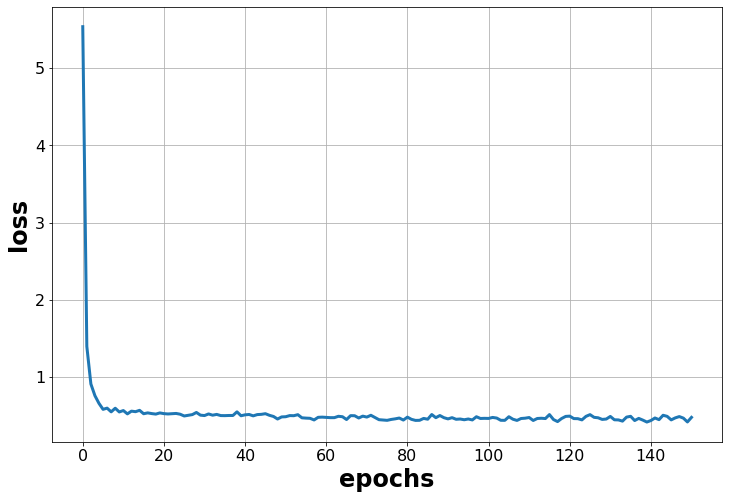

In [23]:
plt.figure(figsize=(12,8))
plt.plot(loss, linewidth=3)
plt.grid()
plt.xlabel('epochs', fontsize=(24), fontweight='bold')
plt.ylabel('loss', fontsize=(24), fontweight='bold')
plt.xticks(fontsize=(16))
plt.yticks(fontsize=(16))

(array([0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 ]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

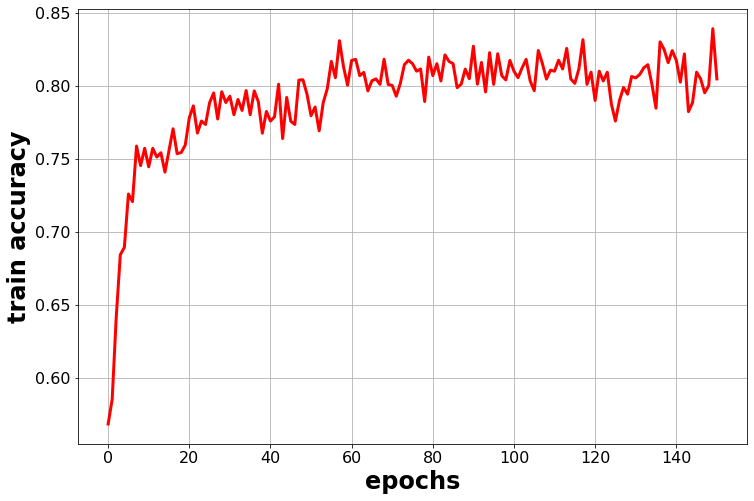

In [24]:
plt.figure(figsize=(12,8))
plt.plot(acc, linewidth=3, color='red')
plt.grid()
plt.xlabel('epochs', fontsize=(24), fontweight='bold')
plt.ylabel('train accuracy', fontsize=(24), fontweight='bold')
plt.xticks(fontsize=(16))
plt.yticks(fontsize=(16))

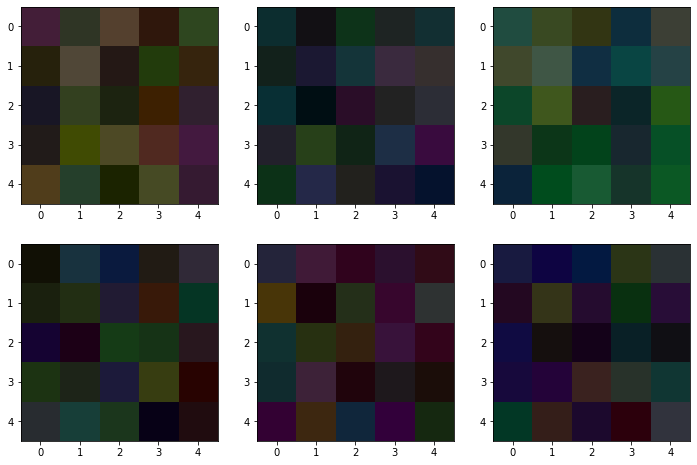

In [56]:
filters1 = cnn.conv1.weight.data.numpy()
fig, ax = plt.subplots(2,3, figsize=(12,8))
ax=ax.flatten()
count =0
for fil in filters1:
    ax[count].imshow(fil.T + abs(np.min(fil.T)))
    count+=1

In [68]:
data = prep.tenX_dataset(DATA, 'data/raman_images', transform=transforms)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

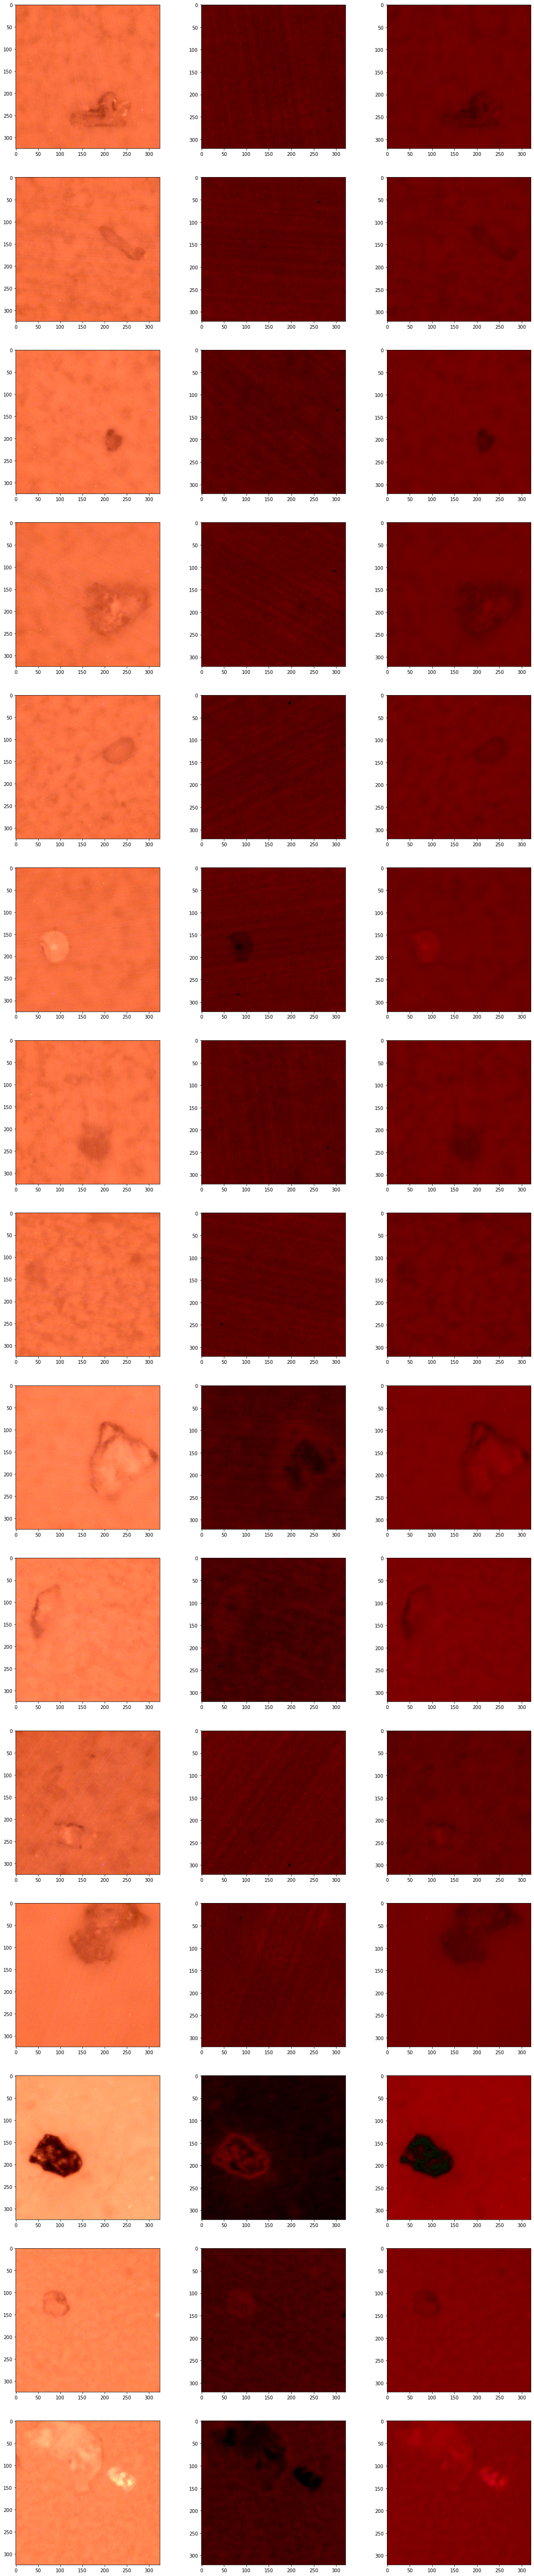

In [133]:
count =0
fig, ax = plt.subplots(15, 3, figsize=(20,100))

for sample in data:
    im = sample['image']
    ax[count, 0].imshow(im.T)
    new = im.unsqueeze(0)
    newim=cnn.conv1(new)
    fin=np.squeeze(newim)
    almost = fin.detach().numpy().T
    ax[count, 1].imshow(almost[:,:,0:3])
    ax[count, 2].imshow
    ax[count, 2].imshow(almost[:,:,3:6])
    count+=1
    if count >14: break

In [134]:
images, labels, predictions, weights, acc = construct.get_predictions(BATCH_SIZE, cnn, test)

In [221]:
def plot_confusion_matrix(labels, pred_labels):
    
    fig = plt.figure(figsize = (10, 10));
    ax = fig.add_subplot(1, 1, 1);
    cm = sklearn.metrics.confusion_matrix(labels, pred_labels);
    cm = sklearn.metrics.ConfusionMatrixDisplay(cm, display_labels = range(2));
    cm.plot(values_format = 'd', cmap = 'Blues', ax = ax)
    ax.grid(False)
    ax.set_xticklabels(['False', 'True'])
    ax.set_yticklabels(['False', 'True'])

In [222]:
l=(labels[:,1] == 1).int().tolist()
print(l)
p=np.array(predictions).flatten()
print(p)

[0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1]
[0 1 0 0 1 0 0 0 0 0 1 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0
 0 0 0 0 1 0 0 1 0 0 1 1 0 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0
 0 0]


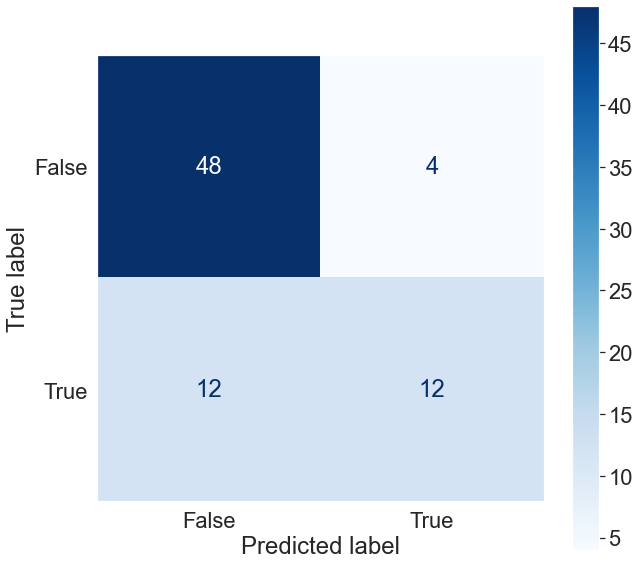

In [223]:
seaborn.set(font_scale=2.0) 
plot_confusion_matrix(l, p)

In [200]:
(labels[:,1] == predictions).float().sum()/len(predictions)

tensor(0.7895)

In [201]:
(labels[:,1] == 0).float().sum()/len(predictions)


tensor(0.6842)

In [ ]:
x = 0
for i in list(DATA['isPlastic']):
    if i is np.array([0, 1]): x+=1
    print(i)

In [ ]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=5, shuffle = True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
models = []
losses = []
train_accs = []
test_accs = []
naive_accs = []
epochs = 150
BATCH_SIZE = 32
criterion = torch.nn.CrossEntropyLoss()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
transforms = torchvision.transforms.Compose([
                            torchvision.transforms.ToPILImage(),
                            torchvision.transforms.RandomRotation((-180,180)),
                            torchvision.transforms.CenterCrop((325)),
                            torchvision.transforms.ToTensor()
                                      ])

for train_idx, test_idx in kf.split(DATA):
    curr_model = myModel()
    train = DATA.iloc[train_idx].reset_index()
    test = DATA.iloc[test_idx].reset_index()
    train_data = prep.tenX_dataset(train, 'data/raman_images', transform=transforms)
    test_data = prep.tenX_dataset(test, 'data/raman_images', transform=transforms)
    cnn, train_loss, train_acc = construct.train(epochs, BATCH_SIZE, 
                                                 train_data, criterion, 'Adam', curr_model, device, with_eval)
    models.append(cnn)
    train_accs.append(train_acc)
    losses.append(train_loss)
    images, labels, predictions, weights, test_acc = construct.get_predictions(BATCH_SIZE, cnn, test_data)
    test_accs.append(test_acc)
    naive_accs.append((labels[:,1] == 0).float().sum()/len(predictions))
    

In [ ]:
df = pd.DataFrame()

In [ ]:
count = 0
for accs in train_accs:
    df[f'train_accs {count}'] = accs
    count+=1

In [ ]:
df.head(10)

In [ ]:
np.mean(np.array((test_accs)))

In [ ]:
test_accs

In [ ]:
np.mean(np.array(naive_accs))

In [ ]:
naive_accs

In [ ]:
for acc in train_accs:
    plt.plot(acc)

In [ ]:
predictions

In [ ]:
labels[24]

In [ ]:
def test_dataset_class():
    filename = '../tests/test_assets/test_labels_unclean.csv'
    image_dir = '../tests/test_assets/test_images'
    
    #Eventually just read in already cleaned labels sheet
    labels = prep_data(pd.read_csv(filename), image_dir)
    
    
    transform = None
    test_dataset = tenX_dataset(labels, image_dir, transform)
    
    #len() check
    length = len(test_dataset)
    expect = 5
    assert length is expect, f'10x dataset length method failed. Got {length}, should be {expect}'
    
    #get_item() check
    samples = []
    keys = ['image', 'plastic','shape','color']
    for i in range(len(test_dataset)):
        assert test_dataset[i]['image'] is not None, 'Got NoneType instead of image'
        isP = test_dataset[i]['plastic']
        assert math.isclose(0,isP) or math.isclose(1,isP), f'plastic not 0 or 1, instead is {isP}'
        length = len(test_dataset[i]['shape'])
        assert length is 4, f'length of shape array not 4, instead is {length}'
        samples.append(test_dataset[i])
        
    shape = samples[0]['shape']
    assert math.isclose(shape[2], 1),  f'wrong shape first image, is {shape}'
    color = samples[0]['color']
    assert math.isclose(color[0], 1), f'wrong color first image, is {color}'
    assert math.isclose(samples[4]['plastic'], 1), 'wrong plastic id 3rd image'
    
test_dataset_class()

In [ ]:
#0 - BASE LINE 82% naive and 88% model test set accuracy
#1 - 9 output CNN1, 18 output CNN2 87% test vs 77% naive
#2 - 3rd linear layer telescoped (12*39*39 -> 2048 -> 256- >2). 93% test, 87% naive
#3 - added a convulutional layer, 12 -> 24 no good
#2d dropout after convolutions led to predicting all pastics, i also read dropouts after convultions is bad, going to try batch normalizations though
#Another paper I read said that non-adaptive optimizers were better for CNN's if thehyperparameters are tunned
#tuned correctly but are much slower so I don't want to even try given it takes me 20min to train already
#adding batchnormalization after convultions improved training results alot, but not test which is weird since
#its supposed to reduce overfitting. Im going to run again overnight